# Zooplankton vs Control

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

In [2]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

# input file

In [3]:
print('What is the new file? (new_file)')
new_file = input('')
print('What year? (year)')
year = input('')

What is the new file? (new_file)


 GNG595


What year? (year)


 20yrclim


In [4]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [5]:
## Jessica's Path 
jluo_path = '/glade/scratch/jluo/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
path_file = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## Gaby's Path 
gabyn_path = '/glade/scratch/gabyn/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

## 10 year climatology from year 53 - 62 representing Jan 2000-Dec 2009
new_path = '/glade/scratch/jluo/archive/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'

In [6]:
### All 63 years of the 2nd cycle (but I will only select the last 20 years for this analysis)
newNCDFfiles1 = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/SPECTRA_[1]*.nc', recursive=True),
                      key=numericalSort)

new = xr.open_mfdataset(newNCDFfiles1[5:25],combine='by_coords')

# Regridded 

In [7]:
zoo3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo3C.[1]*', recursive=True))
zoo3_ds = xr.open_mfdataset(zoo3_inds[5:25],combine='by_coords')
zoo4_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo4C.[1]*', recursive=True))
zoo4_ds = xr.open_mfdataset(zoo4_inds[5:25],combine='by_coords')
zoo5_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo5C.[1]*', recursive=True))
zoo5_ds = xr.open_mfdataset(zoo5_inds[5:25],combine='by_coords')
zoo6_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_zoo6C.[1]*', recursive=True))
zoo6_ds = xr.open_mfdataset(zoo6_inds[5:25],combine='by_coords')

In [8]:
mesozooC_regrid = zoo3_ds.zoo3C+zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

## Zooplankton Observations. 

In [9]:
cope_path = '/glade/u/home/jluo/work/obs/COPEPOD/data/'
cope_files = sorted(glob.glob(cope_path + 'copepod-2012__cmass-m0[1-9]-qtr.nc') + glob.glob(cope_path + 'copepod-2012__cmass-m1[0-2]-qtr.nc'))
dzt = xr.open_mfdataset(cope_files, combine='by_coords')
dzt = dzt.compute()

## the mesh size is 300\mu and the largest size included I think it was 3.4mm? Which would make the ranges for comparison zoo 3, 4, and 5. 

## load z-ratio data 

In [10]:
zratio_path = '/glade/work/jluo/obs/z-ratio/data/1deg_temp_variable/'
dz = xr.open_dataset(zratio_path + 'copepod-2012_zratio_m00.nc', decode_times=False)

In [11]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## plot zooplankton biomass for each zooplankton. 

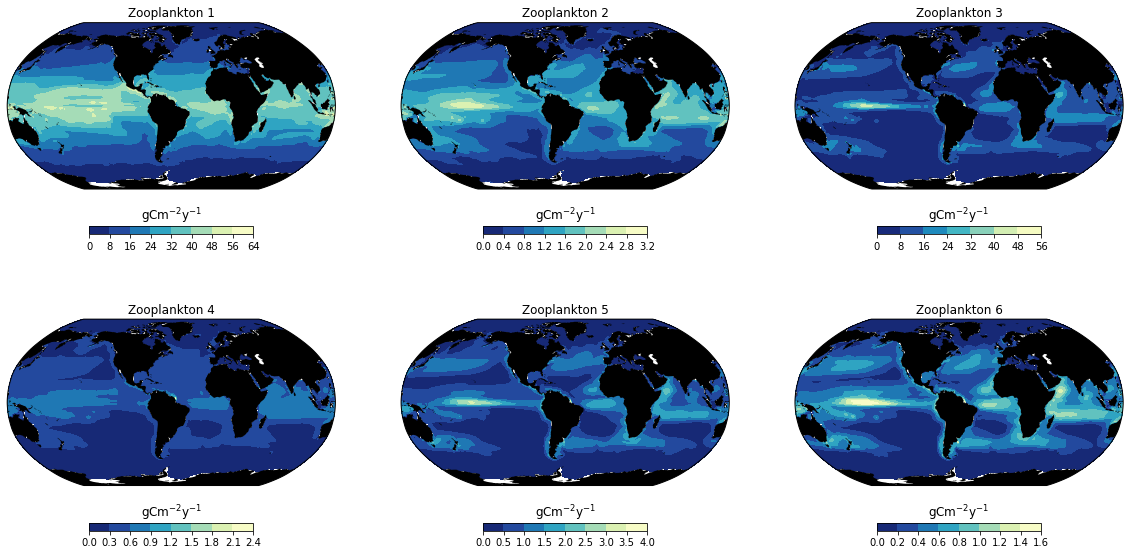

In [12]:
fig = plt.figure(figsize=(20, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo1_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 1');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo2_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 2');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo3_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 3');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo4_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 4');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo5_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 5');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.x_graze_zoo6_zint.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 6');

## total zooplankton biomass

In [13]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
new['zooProd'] = xr.concat([new['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooProd_TOT = new.zooProd * 1.2011e-2 # to g C / m^2 s

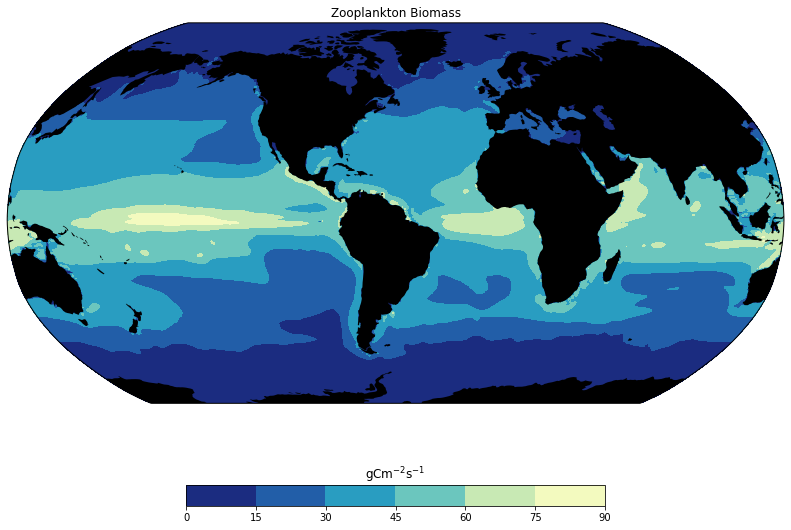

In [14]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zooProd_TOT.mean(dim='time') * (60*60*24*365)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} s^{-1}$')
ax.set_title('Zooplankton Biomass');

## Mesozooplankton biomass

In [15]:
mesozoo = ['zoo4', 'zoo5', 'zoo6']
new['mesozooProd'] = xr.concat([new['x_graze_' + v + '_zint'] for v in mesozoo], dim='var').sum(dim='var')* 1e-2
mesozooProd_TOT = new.mesozooProd * 1.2011e-2 # to g C / m^2 s

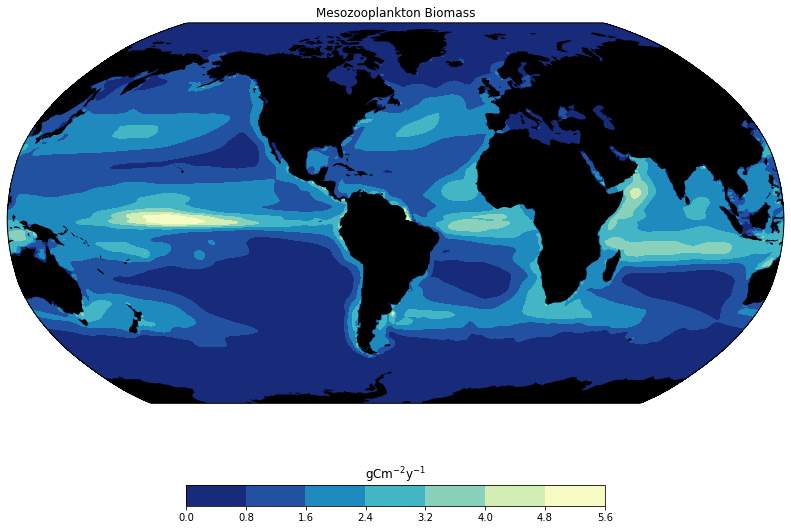

In [16]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (mesozooProd_TOT.mean(dim='time') * (60*60*24*365)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Mesozooplankton Biomass');

## Individual zooplankton Carbon 

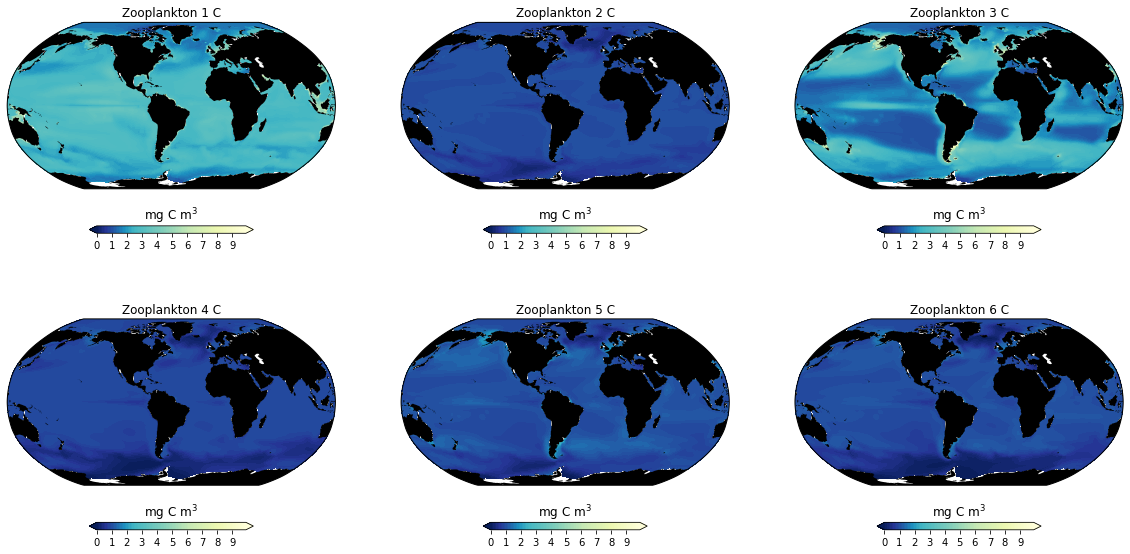

In [17]:
fig = plt.figure(figsize=(20, 10))
lev = np.arange(0, 10, 0.1)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo1C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3 
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm, extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 1 C');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo2C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm,extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 2 C');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo3C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm,extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 3 C');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo4C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3
ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm,extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 4 C');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo5C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3
ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm,extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 5 C');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (new.zoo6C.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011).mean(axis =0)) #mg C/m^3
ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, levels = lev, norm=norm,extend='both',cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton 6 C');
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/zoo_biomass_'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

## Total zooplankton Carbon 

In [18]:
zoo_vars = [v + 'C' for v in ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']]
zooC = xr.concat([new[v] for v in zoo_vars], dim='var').sum(dim='var') #mmol/m^3
zooC = zooC.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

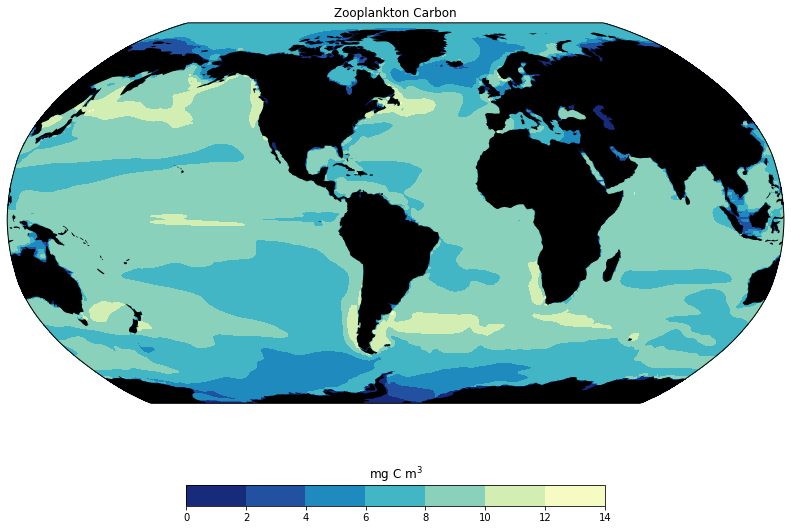

In [19]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zooC.mean(dim='time')))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('Zooplankton Carbon');

## Mesozooplankton Carbon

In [20]:
# colors
lev = (0,2.5,5,7.5,10,12.5, 15,17.5, 20,22.5, 25)

norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=12.5)

In [21]:
mesozoo_vars = [v + 'C' for v in ['zoo3', 'zoo4', 'zoo5']]
mesozooC = xr.concat([new[v] for v in mesozoo_vars], dim='var').sum(dim='var') #mmol/m^3
mesozooC = mesozooC.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

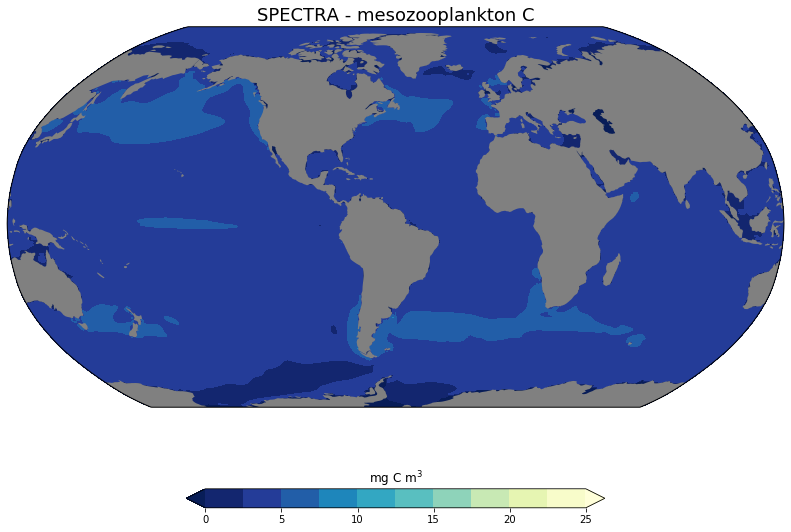

In [22]:
fig = plt.figure(figsize=(15, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (mesozooC.mean(dim='time')))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',extend = 'both',norm=norm, levels=lev, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C $m^3$')
ax.set_title('SPECTRA - mesozooplankton C', fontsize =18);

## Mesozooplankton Observations

Text(0.5, 1.0, 'COPEPOD database - mesozooplankton C (mg C/$m^3$)')

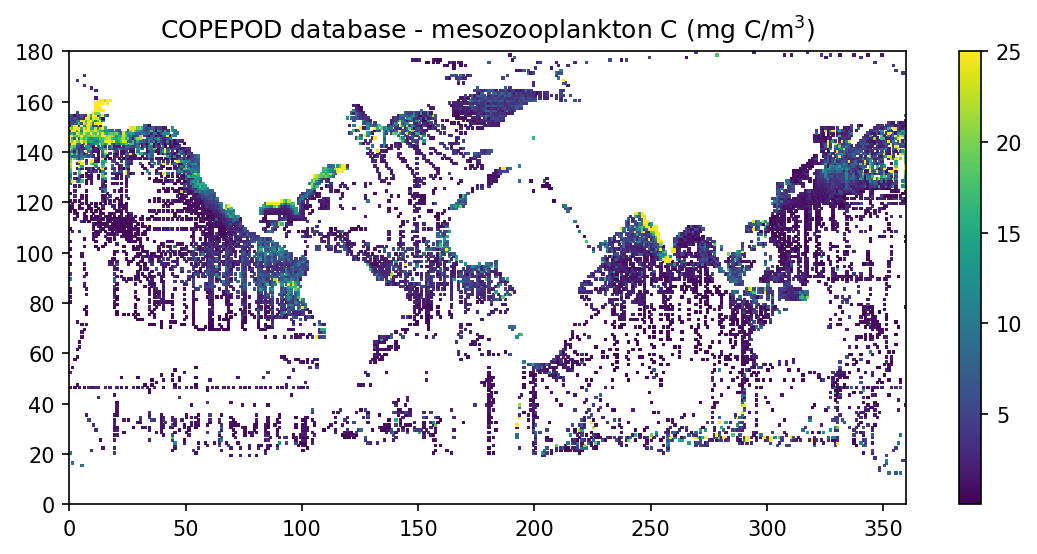

In [23]:
values = dz.carbon_biomass.values[0,:,:]
fig=plt.figure(figsize=(9,4), dpi=150)
plt.pcolor(values, vmax=25)
plt.colorbar()
plt.title('COPEPOD database - mesozooplankton C (mg C/$m^3$)')

Text(0.5, 1.0, 'mg C $m^{-3}$')

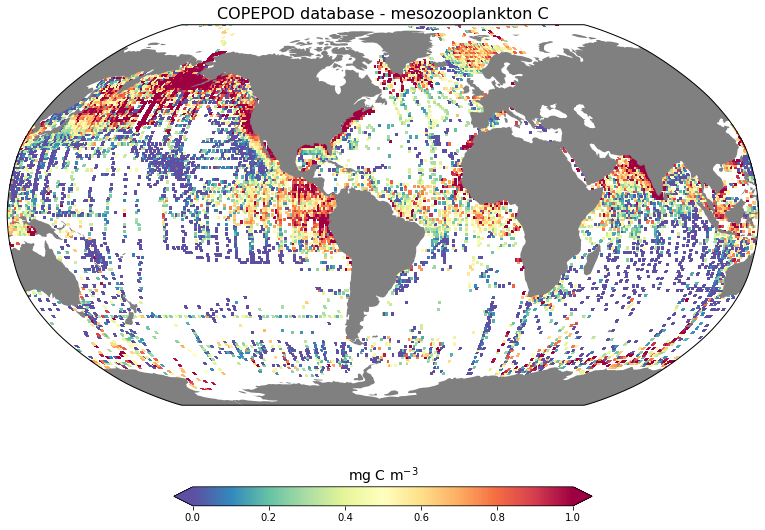

In [24]:
fig = plt.figure(figsize=(15, 10))
lat = dz.lat

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(values), coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin =0,vmax = 1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('COPEPOD database - mesozooplankton C', fontsize =16)
cbar.ax.set_title('mg C $m^{-3}$', fontsize = 14)

## Zooplankton Production 

In [25]:
# sum of grazing to zooplankton mol/m^3 cm/s
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
new['zooGraz'] = xr.concat([new['x_graze_' + v + '_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz_TOT = new.zooGraz * 1.2011e-2 # to g C / m^2 s

In [26]:
# zooplankton loss mol/m^3 cm/s
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
new['zooLoss'] = xr.concat([new[''+ v + '_linear_loss_zint'] for v in zoo_names], dim='var').sum(dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss_TOT = new.zooLoss * 1.2011e-2 # to g C / m^2 s

In [27]:
zooProduction = np.subtract(zooGraz_TOT, zooloss_TOT)

In [28]:
zooProduction.shape

(240, 384, 320)

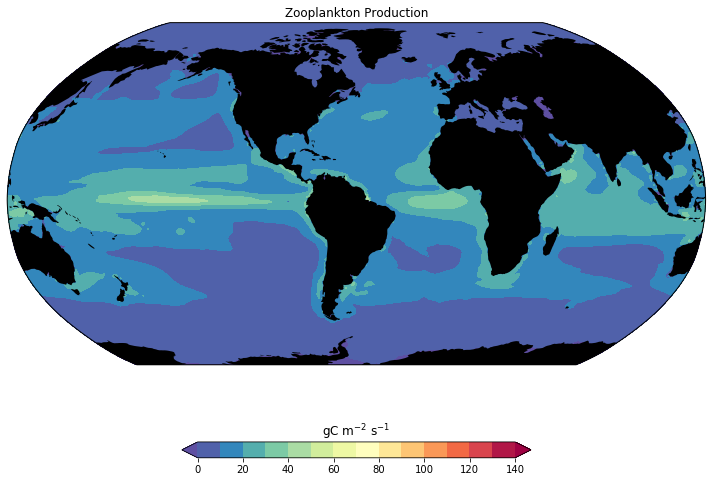

In [29]:
lev = np.arange(0, 150, 10)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=75)

fig = plt.figure(figsize=(10, 7.5))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zooProduction.mean(dim='time') * (60*60*24*365)))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('gC $m^{-2}$ $s^{-1}$')
ax.set_title('Zooplankton Production');
plt.tight_layout()

In [30]:
zoo1_prod = np.subtract(new.x_graze_zoo1_zint, new.zoo1_linear_loss_zint)
zoo2_prod = np.subtract(new.x_graze_zoo2_zint, new.zoo2_linear_loss_zint)
zoo3_prod = np.subtract(new.x_graze_zoo3_zint, new.zoo3_linear_loss_zint)
zoo4_prod = np.subtract(new.x_graze_zoo4_zint, new.zoo4_linear_loss_zint)
zoo5_prod = np.subtract(new.x_graze_zoo5_zint, new.zoo5_linear_loss_zint)
zoo6_prod = np.subtract(new.x_graze_zoo6_zint, new.zoo6_linear_loss_zint)

In [31]:
lev = np.arange(0, 25, 2)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=12.5)

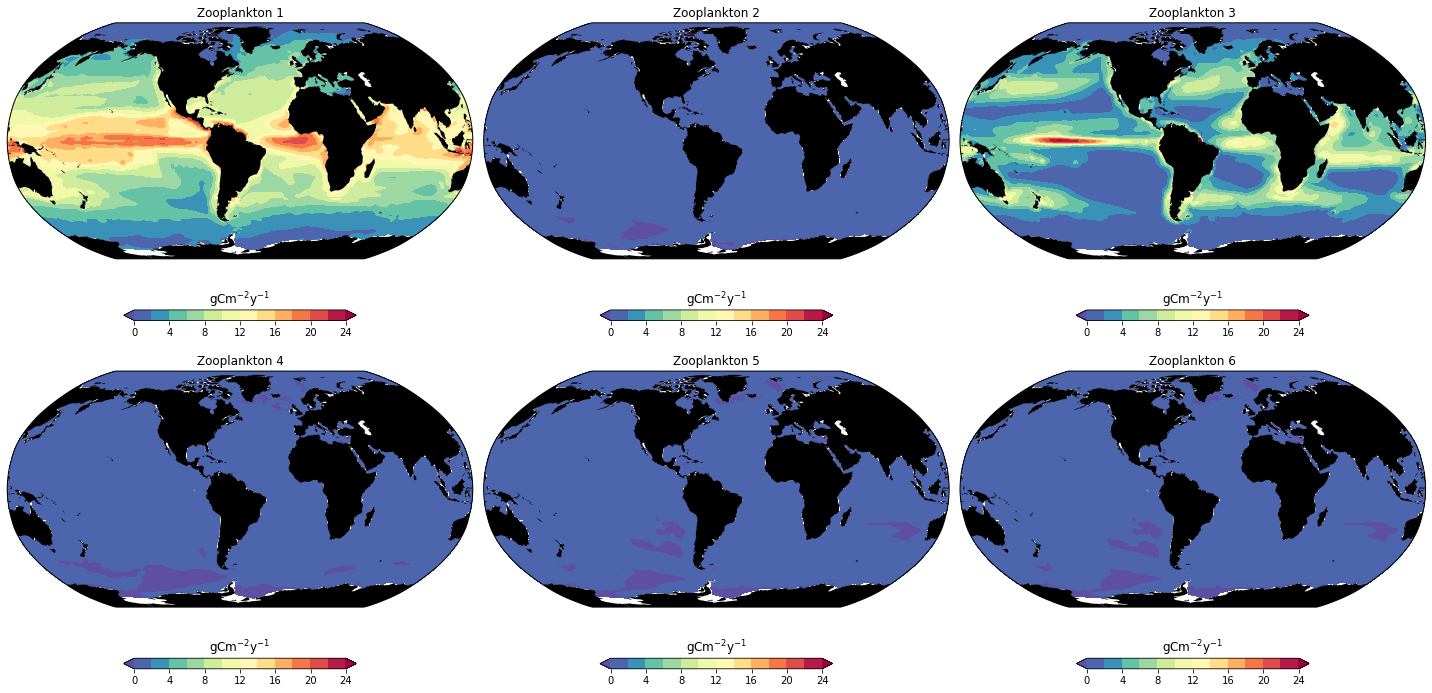

In [32]:
fig = plt.figure(figsize=(20, 10))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo1_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 1');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo2_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 2');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo3_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 3');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo4_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 4');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo5_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 5');

lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, (zoo5_prod.mean(dim='time') * 1e-2*(60*60*24*365)* 1.2011e-2)) #g C / m^2 y
ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('$g C m^{-2} y^{-1}$')
ax.set_title('Zooplankton 6');
plt.tight_layout()

### Now compare point by point with this dataset

In [34]:
mesozooC_regrid = zoo4_ds.zoo4C+zoo5_ds.zoo5C+zoo6_ds.zoo6C #mmol/m^3
mesozooC_regrid = mesozooC_regrid.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

In [35]:
# this finds the summer in the Northern Hemisphere, and the summer in the Southern Hemisphere 
N_hem = np.nanmean(mesozooC_regrid[5:8,90:180,:],axis=0)
S_hem = np.nanmean(mesozooC_regrid[[0,1,-1],0:90,:],axis=0)
arr_summer = np.log10(np.concatenate((S_hem, N_hem), axis=0)) ## This will be the full globe without the mask
arr = np.log10(np.concatenate((S_hem, N_hem), axis=0)) # this will be to only look at the areas that have observations!! 

In [36]:
ind_data = np.isnan(values) # this finds the values that are NaN in the observations

In [37]:
arr[ind_data] = np.nan # this makes the values that are NaN on the obs to NaN in SPECTRA

Text(0.5, 1.0, 'mgC $m^{-3}$')

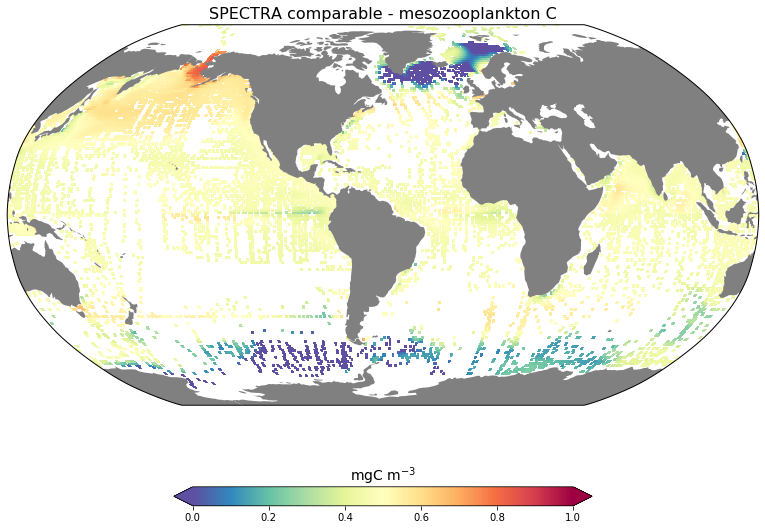

In [38]:
fig = plt.figure(figsize=(15, 10))
lat = dz.lat

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(arr, coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmin=0, vmax = 1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, shrink=0.5, extend = 'both', orientation='horizontal')
ax.set_title('SPECTRA comparable - mesozooplankton C', fontsize =16)
cbar.ax.set_title('mgC $m^{-3}$', fontsize = 14)

## Create a biome comparison between model output and observations form COPEPOD dataset

In [39]:
biome_mask = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124.nc')

region_names = ['Eq-D','Eq-U','S-ST-PS','N-ST-PS','S-ST-SS','N-ST-SS','S-LL-U','N-LL-U','S-SP-SS','N-SP-SS','S-SIZ','N-SIZ']
region_NtoS_index = [11,9,5,3,7,1,0,6,2,4,8,10]
region_NtoS_names = [region_names[i] for i in region_NtoS_index]

biome_mask_x1 = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124_remap.nc') # this is on the pop grid 
biome_mask_x04 = xr.open_dataset('/glade/u/home/gabyn/biomes/biome_mask_3D_0104_0124_remap_x04.nc') # this is in a different grid 

In [40]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [41]:
mesozooC_regrid_ds_inter = np.empty([20,12,180,360])
mesozooC_regrid_ds_inter[:] = np.nan
x = np.array(range(0,240,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(20):
    mesozooC_regrid_ds_inter[i,:,:,:] = mesozooC_regrid[x[i]:x[i]+12,:,:] #mgC m-2

In [42]:
nbiome = len(biome_mask.region.values)
nt = len(dzt.time.values)

### Calculate observations and MARBL data at each region of the biome

biome_means = np.zeros(shape=(nt,nbiome,2))

mesozoo_vars = [v + 'C' for v in ['zoo4', 'zoo5', 'zoo6']]
mesozooC = xr.concat([new[v] for v in mesozoo_vars], dim='var').sum(dim='var') #mmol/m^3
mesozooC = mesozooC.isel(z_t_150m=slice(None,10))

obs_values = dz.carbon_biomass.values[0,:,:]
obss = obs_values[~np.isnan(obs_values)]
obss.shape

np.log10(dzt.carbon_biomass.isel(time=0)).values.shape

biome_mask_x04.REGION_MASK_3D.shape

In [43]:
# averaging over the last 20 years 
mesozooC_20yr = np.nanmean(mesozooC_regrid_ds_inter,axis=0) # this is already in mgC m-2

In [44]:
index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask_x1.REGION_MASK_3D.isel(time=0, region=r).values == 1)
    region_x04 = np.where(biome_mask_x04.REGION_MASK_3D.isel(time=0,region=r).values == 1)
    for t in range(nt):
        # this uses the grid for biomes that is the same as the observed grid. 
        tmp_obs = np.log10(dzt.carbon_biomass.isel(time=t).values[region_x04]) 
        # if there are more than 1% of observations in each biome, then add the value, otherwise, make it a nan. 
        if (len(tmp_obs[~np.isnan(tmp_obs)])/len(region_x04[0]))*100 > 0.5: 
            biome_means[t,i,0] = np.nanmean(tmp_obs)
        else: 
            biome_means[t,i,0] = np.nan
        # log10 of the zooplankton C in each region of the biome. 
        tmp_spec = np.log10(mesozooC_20yr[t,:,:][region]) #mg C/m^3
        biome_means[t,i,1] = np.nanmean(tmp_spec)

index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=r).values == 1)
    region_x04 = np.where(biome_mask_x04.REGION_MASK_3D.isel(time=0,region=r).values == 1)
    for t in range(nt):
        # this uses the grid for biomes that is the same as the observed grid. 
        tmp_obs = np.log10(dzt.carbon_biomass.isel(time=t).values[region_x04]) 
        # if there are more than 1% of observations in each biome, then add the value, otherwise, make it a nan. 
        if (len(tmp_obs[~np.isnan(tmp_obs)])/len(region_x04[0]))*100 > 0.5: 
            biome_means[t,i,0] = np.nanmean(tmp_obs)
        else: 
            biome_means[t,i,0] = np.nan
        # log10 of the zooplankton C in each region of the biome. 
        tmp_spec = np.log10(mesozooC.isel(time=t).mean(dim='z_t_150m').values[region] * 12.011) #mg C/m^3
        biome_means[t,i,1] = np.nanmean(tmp_spec)

index = pd.Index(region_NtoS_names, name='region')
nbiome = len(region_NtoS_names)
biome_means = np.zeros(shape=(nt,nbiome,2))

photoC_data={}
for i in range(nbiome):
    r = region_NtoS_index[i]
    name = region_NtoS_names[i]
    region = np.where(biome_mask.REGION_MASK_3D.isel(time=0, region=r).values == 1)
    region_x04 = np.where(biome_mask_x04.REGION_MASK_3D.isel(region=r).values == 1)
    for t in range(nt):
        tmp_spec = np.log10(mesozooC.isel(time=t).mean(dim='z_t_150m').values[region] * 12.011) #mg C/m^3
        biome_means[t,i,1] = np.nanmean(tmp_spec)
        tmp_obs = np.log10(dzt.carbon_biomass.isel(time=t).values[region_x04])
        biome_means[t,i,0] = np.nanmean(tmp_obs)


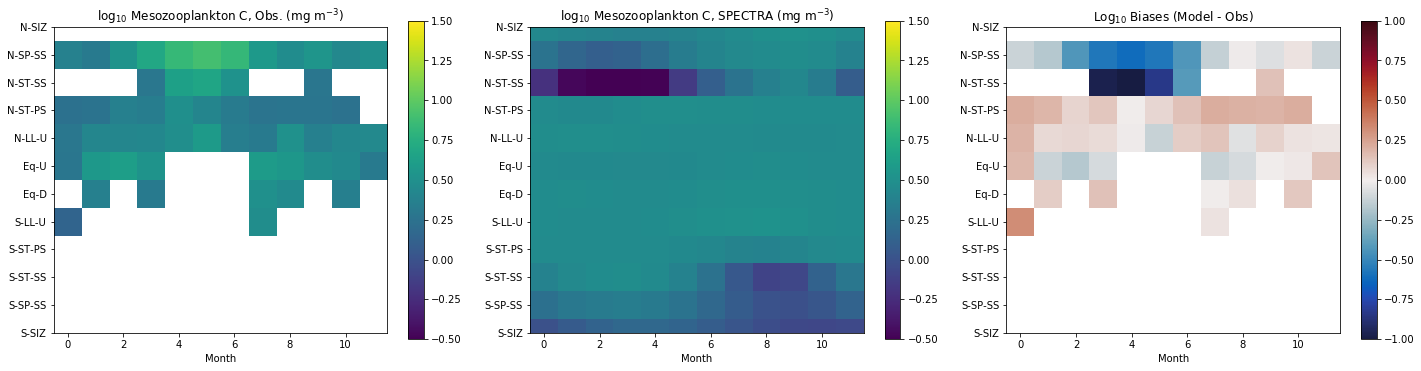

In [45]:
Models = ['Obs.', 'SPECTRA']

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(20,5))

for i in range(2):    
    f = plt.subplot(gs[0,i])
    plt.imshow(biome_means[:,:,i].T, vmax=1.5,vmin=-0.5)
    plt.yticks(range(nbiome), region_NtoS_names)
    plt.xlabel('Month')
    plt.colorbar()
    plt.title('$log_{10}$ Mesozooplankton C, ' +Models[i] + ' (mg $m^{-3}$)')

# bias plot
f = plt.subplot(gs[0,2])
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xlabel('Month')
plt.title('$Log_{10}$ Biases (Model - Obs)')
plt.colorbar()


plt.tight_layout()

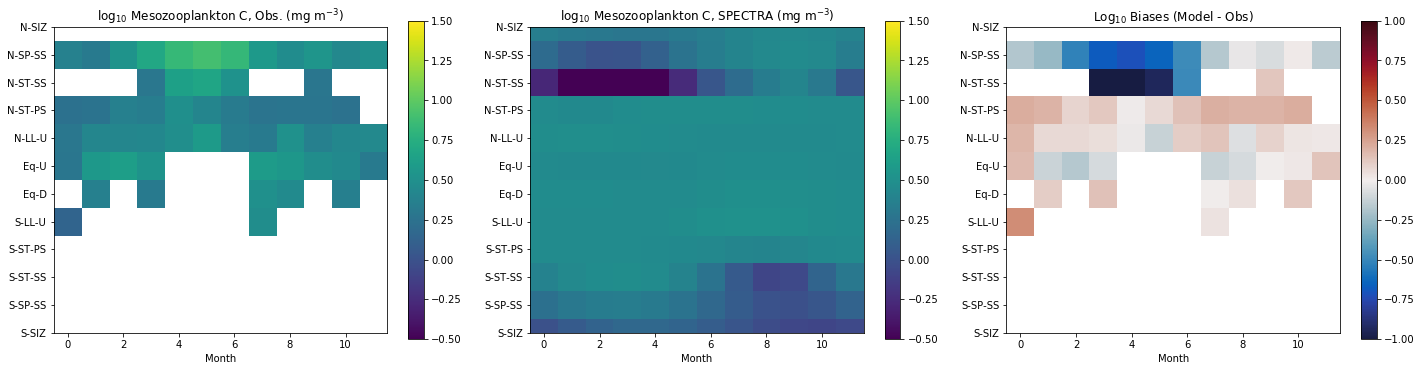

In [50]:
Models = ['Obs.', 'SPECTRA']

gs = gridspec.GridSpec(1,3)
fig = plt.figure(figsize=(20,5))

for i in range(2):    
    f = plt.subplot(gs[0,i])
    plt.imshow(biome_means[:,:,i].T, vmax=1.5,vmin=-0.5)
    plt.yticks(range(nbiome), region_NtoS_names)
    plt.xlabel('Month')
    plt.colorbar()
    plt.title('$log_{10}$ Mesozooplankton C, ' +Models[i] + ' (mg $m^{-3}$)')

# bias plot
f = plt.subplot(gs[0,2])
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xlabel('Month')
plt.title('$Log_{10}$ Biases (Model - Obs)')
plt.colorbar()


plt.tight_layout()

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/mesozooplankton_biomass_and_bias'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')


In [68]:
arr_summer.shape

(180, 360)

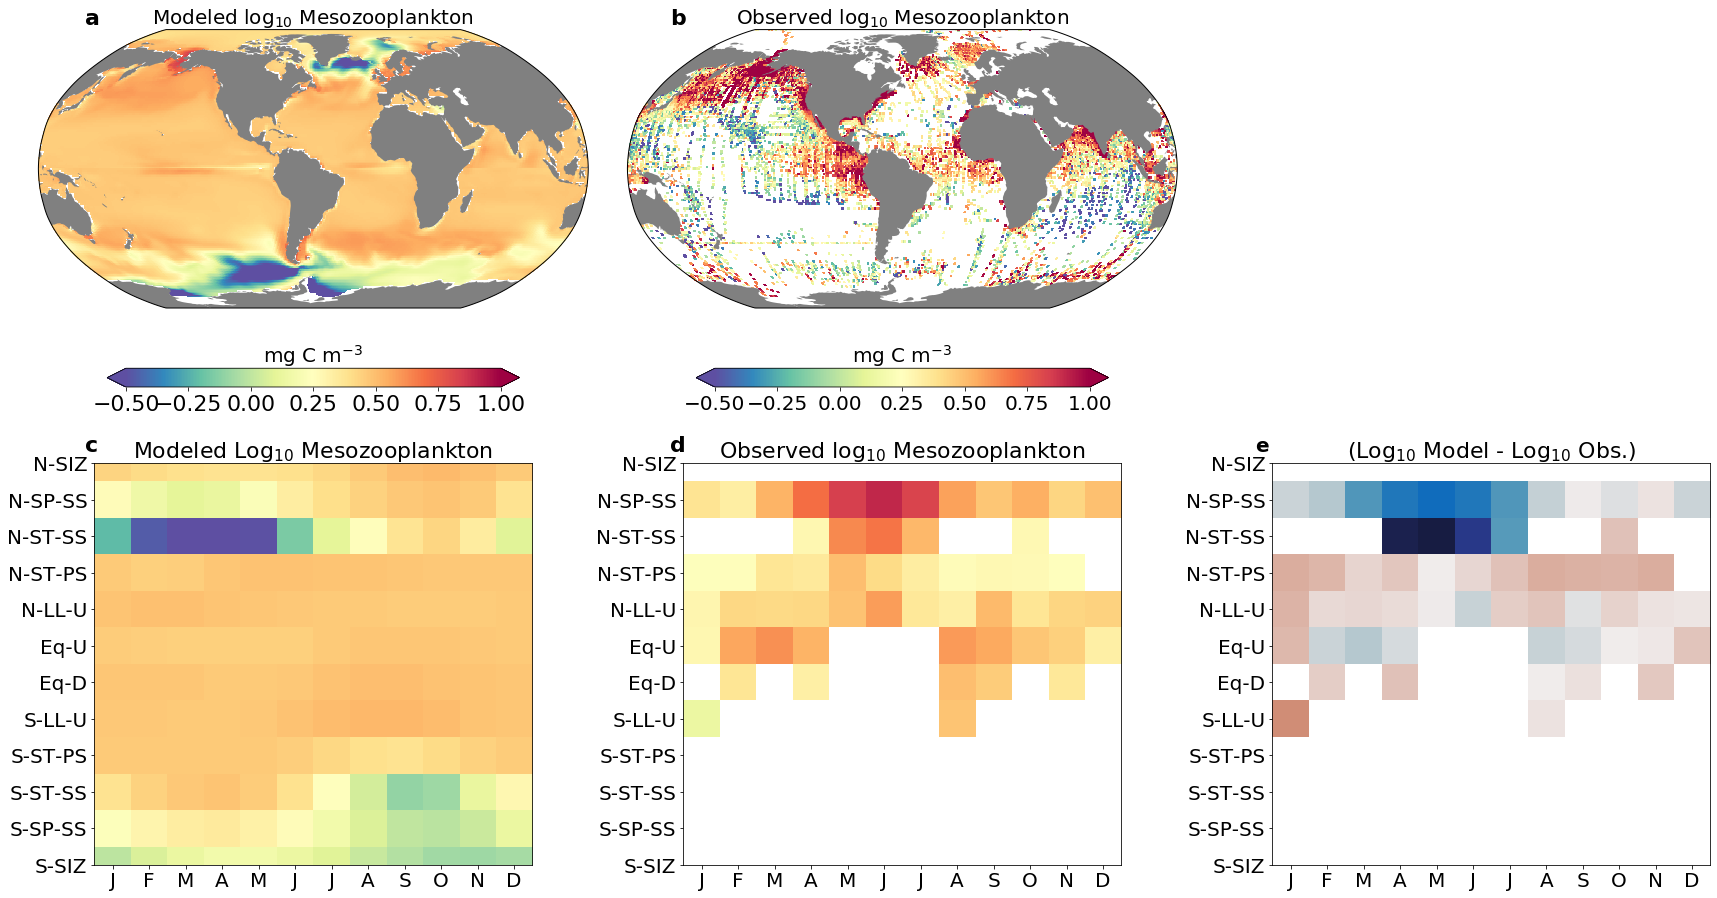

In [50]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = dz.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(values), coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmax = 1, vmin = -0.5)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink=0.75, extend = 'both', orientation='horizontal')
ax.set_title('Observed $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-3}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.06, 0.975, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
zoo, lon = add_cyclic_point(arr_summer, coord=zoo3_ds.lon, axis=1)
latt = zoo3_ds.lat
#cf = ax.pcolor(lon, lat, zoo, cmap='Spectral_r',transform=ccrs.PlateCarree(),vmin = 1.5, vmax =3.2)
#lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, np.log10(arr_summer))
cf = ax.pcolor(lon, latt, zoo, cmap='Spectral_r', transform=ccrs.PlateCarree(), vmax = 1, vmin = -0.5);
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, shrink=0.75, extend = 'both',orientation='horizontal')
cb.ax.set_title('mg C $m^{-3}$', fontsize = 20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton',fontsize =20);
fig.text(0.385, 0.975, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmin = -0.5, vmax=1,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $log_{10}$ Mesozooplankton', fontsize=22)
fig.text(0.06, 0.5, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmin = -0.5, vmax=1,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Mesozooplankton',fontsize=22)
fig.text(0.385, 0.5, 'd',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=22)
fig.text(0.71, 0.5, 'e',fontsize=20, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/mesozoo_diff_summer_corrected.png',dpi=600, bbox_inches='tight')

## Create a figure with all of them! 

In [46]:
# colors
lev = np.arange(-0.1, 0.755, 0.01)
norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.325)

mesozoo_vars = [v + 'C' for v in ['zoo4', 'zoo5', 'zoo6']]
mesozooC_top = xr.concat([new[v] for v in mesozoo_vars], dim='var').sum(dim='var') #mmol/m^3
mesozooC_top = mesozooC_top.isel(z_t_150m=slice(None,10)).mean(dim='z_t_150m')* 12.011 #mg C/m^3

In [52]:
N_hem = np.nanmean(mesozooC_top[5:8,0:192,:],axis=0)
S_hem = np.nanmean(mesozooC_top[[0,1,-1],192:384,:],axis=0)

In [53]:
arrr = np.concatenate((N_hem, S_hem), axis=0)

In [54]:
arr.shape

(180, 360)

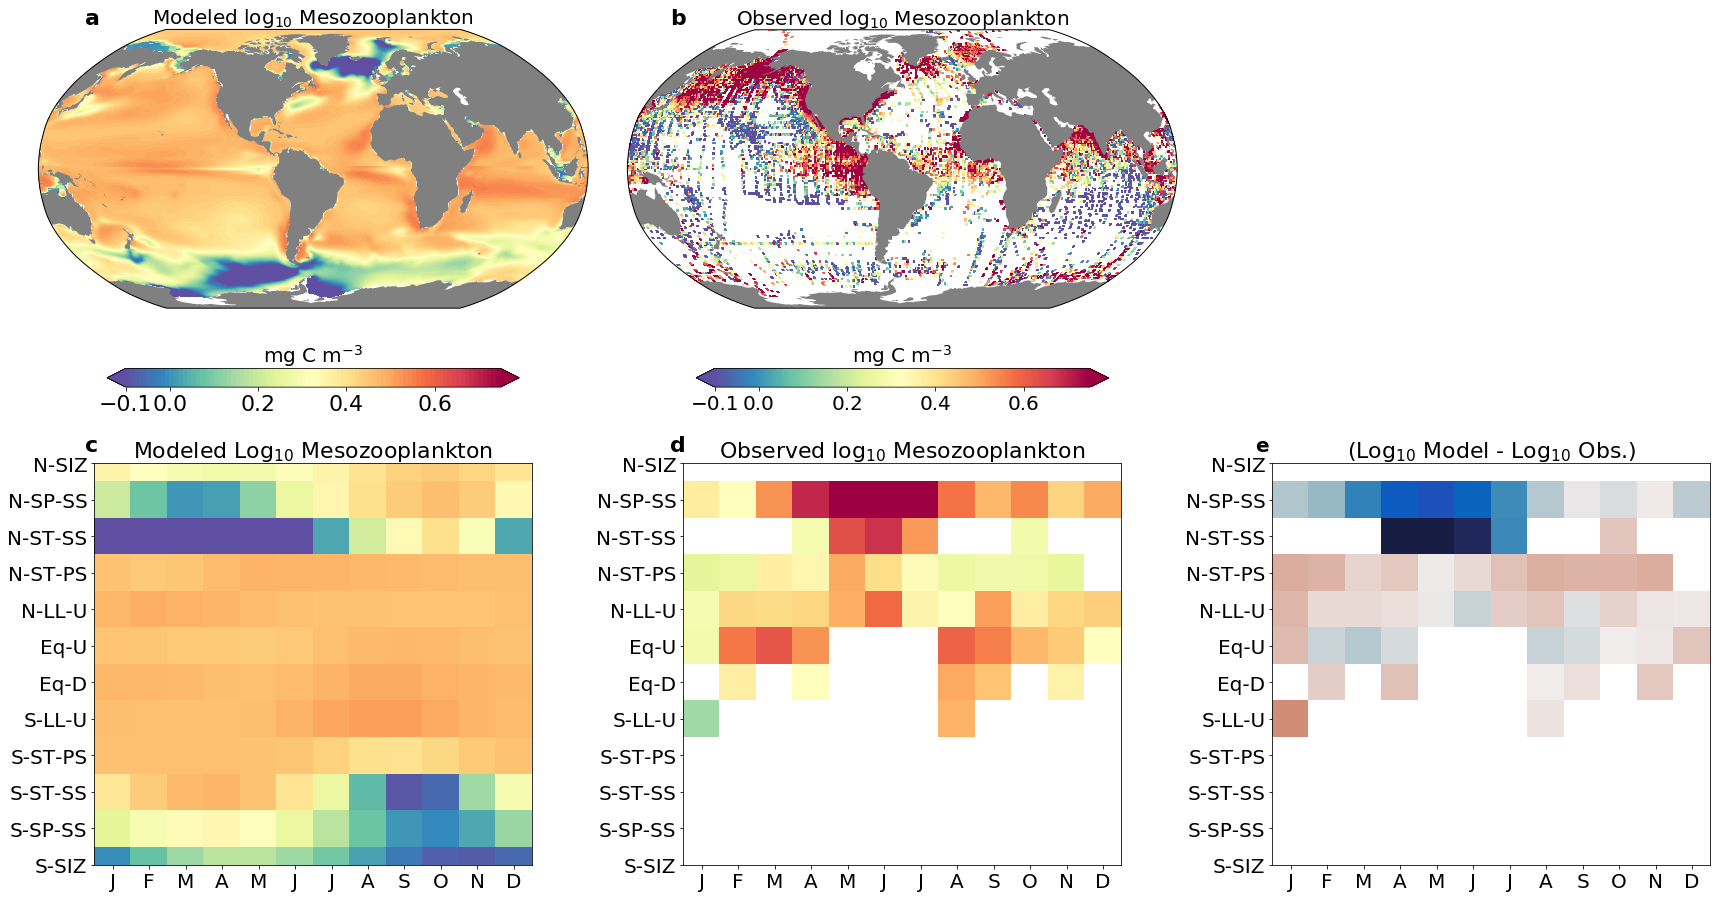

In [55]:
fig = plt.figure(figsize=(25, 12.5))
Models = ['Obs.', 'SPECTRA']
lat = dz.lat
ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(values), coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='Spectral_r',transform=ccrs.PlateCarree(), vmax = 0.75, vmin = -0.1)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,ticks = [-0.1, 0, 0.2, 0.4, 0.6],shrink=0.75, extend = 'both', orientation='horizontal')
ax.set_title('Observed $log_{10}$ Mesozooplankton', fontsize=20)
cbar.ax.set_title('mg C $m^{-3}$', fontsize = 20)
cbar.ax.tick_params(labelsize=20)
fig.text(0.06, 0.975, 'a',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, np.log10(arrr))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels = lev, norm=norm, extend = 'both', transform=ccrs.PlateCarree(), vmax = 0.75, vmin = -0.1);
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,ticks = [-0.1, 0, 0.2, 0.4, 0.6], shrink=0.75, extend = 'both',orientation='horizontal')
cb.ax.set_title('mg C $m^{-3}$', fontsize = 20)
cb.ax.tick_params(labelsize=20)
ax.set_title('Modeled $log_{10}$ Mesozooplankton',fontsize =20);
fig.text(0.385, 0.975, 'b',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 5)
plt.imshow(biome_means[:,:,0].T, vmin = -0.1, vmax=0.75,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Observed $log_{10}$ Mesozooplankton', fontsize=22)
fig.text(0.06, 0.5, 'c',fontsize=22, fontweight='bold')

ax = fig.add_subplot(2, 3, 4)
plt.imshow(biome_means[:,:,1].T, vmin = -0.1, vmax=0.75,cmap='Spectral_r')
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
plt.title('Modeled $Log_{10}$ Mesozooplankton',fontsize=22)
fig.text(0.385, 0.5, 'd',fontsize=22, fontweight='bold')

# bias plot
ax = fig.add_subplot(2, 3, 6)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=22)
fig.text(0.71, 0.5, 'e',fontsize=20, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['J', 'F', 'M', 'A','M','J','J','A','S','O','N','D'])
plt.xticks(fontsize= 20 );plt.yticks(fontsize= 20 );
cb.ax.tick_params(labelsize=22)
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/mesozoo_diff_summer_zoo4_zoo6_cnew_'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

fig = plt.figure(figsize=(15, 5))
lat = dz.lat
ax = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
phyto, lon = add_cyclic_point(np.log10(values), coord=dz.lon, axis=1)
cf = ax.pcolor(lon, lat, phyto, cmap='YlGnBu_r',transform=ccrs.PlateCarree(), vmin = -2, vmax = 2)
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf, ticks=[ -2,-1, 0,1,2],shrink=0.5, extend = 'both', orientation='horizontal')
plt.title('Observed $log_{10}$ Mesozooplankton C',fontsize=14)
cbar.ax.set_title('mg C/$m^3$', fontsize = 12)
cbar.ax.tick_params(labelsize=12)
fig.text(0.09, 0.89, 'a',fontsize=14, fontweight='bold')

ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
lon, lat, zoo = adjust_pop_grid(new.TLONG, new.TLAT, np.log10(mesozooC_top.mean(dim='time')))
cf = ax.contourf(lon, lat, zoo, cmap='YlGnBu_r',extend = 'both',norm=norm, levels=lev, transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf, ticks=[ -2,-1, 0,1,2],shrink=0.5, orientation='horizontal')
cb.ax.set_title('mg C/$m^3$', fontsize = 12)
cb.ax.tick_params(labelsize=12)
plt.title('Modeled $Log_{10}$ Mesozooplankton C',fontsize=14)
fig.text(0.52, 0.89, 'b',fontsize=14, fontweight='bold')

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/mesozoo_map'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')

fig = plt.figure(figsize=(25, 6))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(biome_means[:,:,0].T, vmax=2,vmin=-2)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 16 );plt.yticks(fontsize= 16 );
plt.title('Observed $log_{10}$ Mesozooplankton C', fontsize=18)
fig.text(0.075, 0.95, 'c',fontsize=18, fontweight='bold')

ax = fig.add_subplot(1, 3, 1)
plt.imshow(biome_means[:,:,1].T, vmax=2,vmin=-2)
plt.yticks(range(nbiome), region_NtoS_names)
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 16 );plt.yticks(fontsize= 16 );
plt.title('Modeled $Log_{10}$ Mesozooplankton C',fontsize=18)
fig.text(0.395, 0.95, 'd',fontsize=18, fontweight='bold')

# bias plot
ax = fig.add_subplot(1, 3, 3)
biome_diffs = biome_means[:,:,1] - biome_means[:,:,0]
a = plt.imshow(biome_diffs.T, vmax=1.0, vmin=-1.0, cmap=cmocean.cm.balance)
plt.yticks(range(nbiome), region_NtoS_names)
plt.title('($Log_{10}$ Model - $Log_{10}$ Obs.)',fontsize=18)
fig.text(0.71, 0.95, 'e',fontsize=18, fontweight='bold')
plt.xticks([0, 1, 2, 3,4,5,6,7,8,9,10,11], ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xticks(fontsize= 16 );plt.yticks(fontsize= 16 );
cb = plt.colorbar(a,shrink=0.5,extend = 'both')
cb.ax.set_ylabel('mg C/$m^3$',fontsize=18)
cb.ax.tick_params(labelsize=16)
fig.tight_layout()

#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/mesozoo_grid'+new_file+'_'+year+'_year.png',dpi=600, bbox_inches='tight')